# Modelling and Evaluating 

## Objectives

- Answer business requirement 2:
  - The client is interested to tell wheterh a given leaf is covered with powdery mildew 

## Inputs

- inputs/cherryleaves_dataset/cherry-leaves/train
- inputs/cherryleaves_dataset/cherry-leaves/test
- inputs/cherryleaves_dataset/cherry-leaves/validation
- image shape embeddings

## Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

## Comments | Insights | Conclusions

- CNN with less parameters to train but aceptable accuracy
  - decrease hidden layers and output units model.add(Dense(8 ...
- Activation function 'leaky_relu'
  - why it's better than relu according to research
- decrease learning rate (lr) of RMSprop
  - longer time to train the model but higher accuracy
- increase batch size
-  augment more images
- images black and white
  - does it make any difference, maybe easier to train?

---

## Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf
from matplotlib.image import imread

---

## Set working directory

In [2]:
cwd = os.getcwd()

In [3]:
os.chdir('/workspace/Detection-Cherry-Powdery-Mildew')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/Detection-Cherry-Powdery-Mildew'

---

## Set input directories

Set train, validation and test paths

In [5]:
my_data_dir = 'inputs/cherryleaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train' 
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [6]:
version = 'v2'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set label names

In [7]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


## Set image shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## Number of images in train, test and validation sets

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




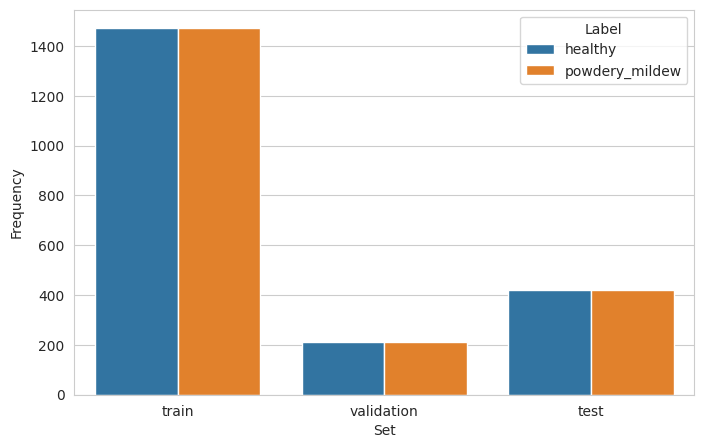

In [9]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

## Image data augmentation

### Import ImageDataGenerator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Initialize ImageDataGenerator

In [11]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Augment training image set

In [64]:
batch_size = 32
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented training image set

(32, 256, 256, 3)


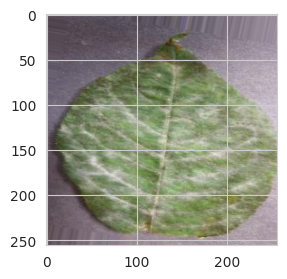

(32, 256, 256, 3)


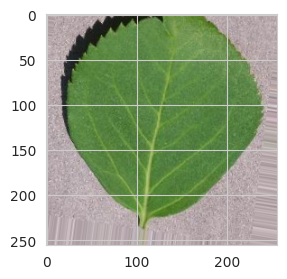

(32, 256, 256, 3)


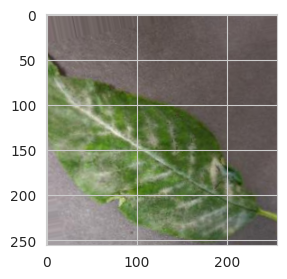

In [13]:
%matplotlib inline
for _ in range(3):
    plt.figure(figsize=(3, 3))
    img, label = train_set.next()
    print(img.shape)  # (20,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Augment validation image set

In [14]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented validation image set

In [15]:
for _ in range(3):
    plt.figure(figsize=(3, 3))
    img, label = validation_set.next()
    print(img.shape)  # (20,256,256,3)
    # plt.imshow(img[0])
    # plt.show()

(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)


<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

### Augment test image set

In [16]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented test image set

In [17]:
for _ in range(3):
    plt.figure(figsize=(3, 3))
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    # plt.imshow(img[0])
    # plt.show()

(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)


<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

### Save class_indices

In [18]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v2/class_indices.pkl']

---

## Model Creation

### Import model packages

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop

### Model

- Rationale when defining the network layers (hidden, output), compiling the model and setting hyperparmeters (filter, kernel, activation function, pool size). 
  - hidden layers
  - output layer
  - model compilation
  - setting hyperparameters
- The required explanations in the notebook have to include references from where you have
seen as such approach like a given section from our course or an article you saw on the internet.
The last example to mention here is to version your generated outputs,
including files like machine learning models or pipelines and plots.

In [20]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),            
              input_shape=image_shape, activation=tf.keras.layers.LeakyReLU(alpha=0.01), ))       
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation=tf.keras.layers.LeakyReLU(alpha=0.01), ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3),
              input_shape=image_shape, activation=tf.keras.layers.LeakyReLU(alpha=0.01), ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3),
              input_shape=image_shape, activation=tf.keras.layers.LeakyReLU(alpha=0.01), ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(16, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', 
                  optimizer=RMSprop(learning_rate=0.0017), 
                  metrics=['accuracy'])

    return model

### Model Summary

In [21]:
create_tf_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       1

2023-01-24 21:10:37.705952: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Early Stopping

In [22]:
from tensorflow.keras.callbacks import EarlyStopping #ModelCheckpoint
early_stop = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1, patience=2)
#early_stop = EarlyStopping(monitor='val_loss', patience=2)
#filepath = "best_model.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

### Fit model for training

In [23]:
model = create_tf_model()
model.fit(train_set,
          batch_size=batch_size,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          #callbacks=[checkpoint],
          verbose=1
          )

2023-01-24 21:10:38.627383: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
92/92 [==============================] - 188s 2s/step - loss: 1.1560 - accuracy: 0.5893 - val_loss: 0.3635 - val_accuracy: 0.8976
Epoch 2/25
92/92 [==============================] - 194s 2s/step - loss: 0.3880 - accuracy: 0.8736 - val_loss: 0.3513 - val_accuracy: 0.8786
Epoch 3/25
92/92 [==============================] - 196s 2s/step - loss: 0.3023 - accuracy: 0.9175 - val_loss: 0.1184 - val_accuracy: 0.9738
Epoch 4/25
92/92 [==============================] - 187s 2s/step - loss: 0.2321 - accuracy: 0.9358 - val_loss: 0.0760 - val_accuracy: 0.9857
Epoch 5/25
92/92 [==============================] - 204s 2s/step - loss: 0.3299 - accuracy: 0.9419 - val_loss: 0.0678 - val_accuracy: 0.9857
Epoch 6/25
92/92 [==============================] - 180s 2s/step - loss: 0.3676 - accuracy: 0.9141 - val_loss: 0.3557 - val_accuracy: 0.9833
Epoch 7/25
92/92 [==============================] - 203s 2s/step - loss: 0.2074 - accuracy: 0.9385 - val_loss: 0.8313 - val_accuracy: 0.8476
Epoch 00007: 

### Save model

In [24]:
model.save('outputs/v2/powdery_mildew_model.h5')

---

## Model Performance

### Model learining curve

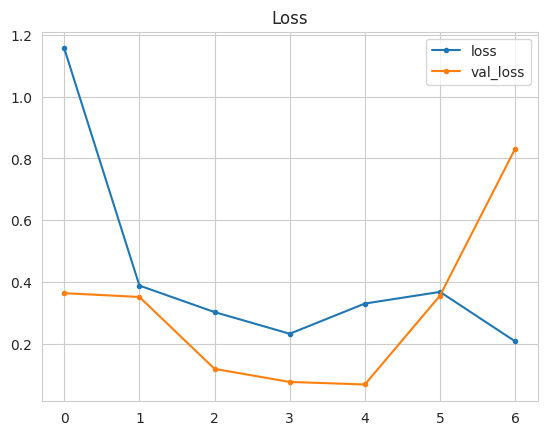

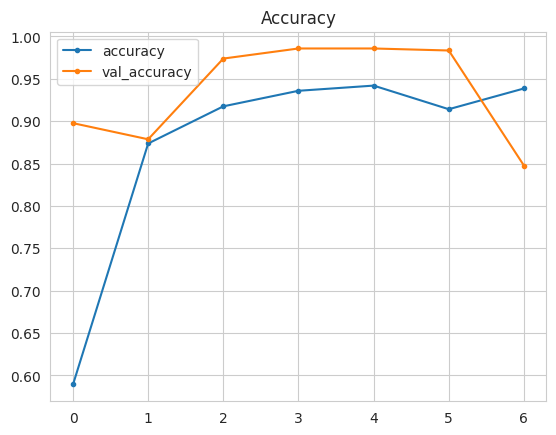

In [25]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

## Model Evaluation

### Load saved model

In [26]:
from keras.models import load_model
model = load_model('outputs/v2/powdery_mildew_model.h5')

### Evaluate model on test set

### Accuracy

In [27]:
evaluation = model.evaluate(test_set, batch_size=batch_size)
print("Model accuracy: {:.2f}%".format(evaluation[1] * 100))
print("Model Loss: ",evaluation[0])

27/27 [==============================] - 13s 465ms/step - loss: 0.4872 - accuracy: 0.8519
Model accuracy: 85.19%
Model Loss:  0.48717209696769714


### ROC Curve

In [28]:
STEP_SIZE_TEST = validation_set.n//validation_set.batch_size
validation_set.reset()
preds = model.predict(validation_set,verbose=1)

14/14 [==============================] - 13s 946ms/step


In [29]:
import sklearn
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

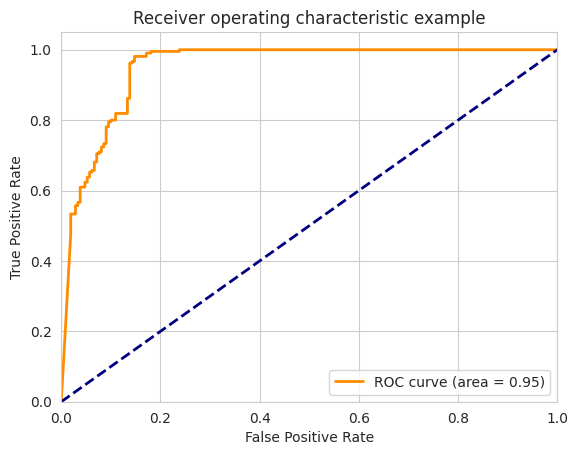

In [30]:
fpr, tpr, _ = roc_curve(validation_set.classes, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Classification Report

In [97]:
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score 

Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)
print('Classification Report:\n----------------------\n')
print(classification_report(test_set.classes, y_pred, target_names=labels))

Classification Report:
----------------------

                precision    recall  f1-score   support

       healthy       0.50      1.00      0.67       422
powdery_mildew       0.00      0.00      0.00       422

      accuracy                           0.50       844
     macro avg       0.25      0.50      0.33       844
  weighted avg       0.25      0.50      0.33       844



/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion Matrix
https://stackoverflow.com/questions/69239296/how-to-get-confusion-matrix-and-roc-curve-when-using-flow-from-directory

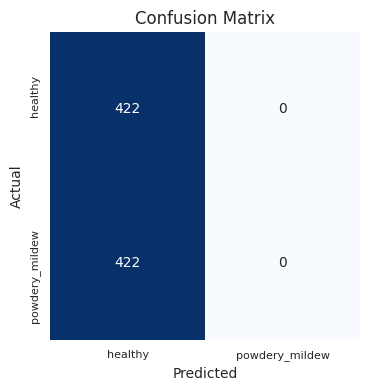

In [143]:
def cm(test_gen, model):
    preds=model.predict(test_gen)    
    labels=test_gen.labels 
    classes=list(test_gen.class_indices.keys()) # ordered lst of class names 
    pred_list=[ ] # will store the predicted classes here
    true_list=[]
    for i, p in enumerate (preds):
        index=np.argmax(p)
        pred_list.append(classes[index])
        true_list.append(classes[labels[i]])
    y_pred=np.array(pred_list)
    y_true=np.array(true_list)
    #clr = classification_report(y_true, y_pred, target_names=classes)
    #print("Classification Report:\n----------------------\n", clr)
    cm = confusion_matrix(y_true, y_pred)        
    length=len(classes)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(length)+.5, classes, rotation= 0, fontsize=8)
    plt.yticks(np.arange(length)+.3, classes, rotation=90, fontsize=8)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

cm(test_set, model)

### Save evaluation pickle

In [35]:
joblib.dump(value=evaluation,
            filename=f"outputs/v2/evaluation.pkl")

['outputs/v2/evaluation.pkl']

---

## Predict on new data

### Load random image as PIL

Image shape: (256, 256), Image mode: RGB


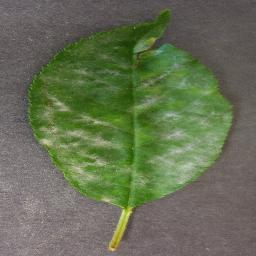

In [140]:
from tensorflow.keras.preprocessing import image

pointer = 421
label = labels[1] # select healthy or powdery_mildew

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image


### Convert image to array and prepare for prediction

In [141]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


### Predict class probabilities

In [142]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

0.99878955
powdery_mildew
